In [1]:
# Necessary
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchdiffeq import odeint_adjoint as odeint
from jupyterthemes import jtplot
from utils import *
jtplot.style(theme="chesterish")
 # CONSTANT 
device = "cuda"
EPOCHS=1
BATCH_SIZE=32
IMG_SIZE=(32,32,3)

In [2]:
# Load data
DIR = "./data/mnist/"
MNIST = torchvision.datasets.MNIST(DIR,
                                   train=True,
                                   transform=None,
                                   target_transform=None, download=True)
ls = enumerate(MNIST)

#ds_len_, normal_ds_, pertubed_ds_ = preprocess_data(MNIST)


In [3]:
cnn_model = Network()
ode_func = ODEBlock()
ode_model = ODENet(ode_func)


# In[4]:


def model_state_dict_parallel_convert(state_dict, mode):
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    if mode == 'to_single':
        for k, v in state_dict.items():
            name = k.replace("module.","")  # remove 'module.' of DataParallel
            new_state_dict[name] = v
    elif mode == 'to_parallel':
        for k, v in state_dict.items():
            name = 'module.' + k  # add 'module.' of DataParallel
            new_state_dict[name] = v
    elif mode == 'same':
        new_state_dict = state_dict
    else:
        raise Exception('mode = to_single / to_parallel')

    return new_state_dict 
ode_state_dict = torch.load("./model/ode_origin/mnist_origin_origin.pt",map_location=torch.device('cuda'))
ode_state_dict = model_state_dict_parallel_convert(ode_state_dict, mode="to_single")
ode_model.load_state_dict(ode_state_dict)
cnn_state_dict = torch.load("./model/cnn_origin/mnist_origin_origin.pt",map_location=torch.device('cuda'))
cnn_state_dict = model_state_dict_parallel_convert(cnn_state_dict, mode="to_single")
cnn_model.load_state_dict(cnn_state_dict)

ode_model = ode_model.to(device)
cnn_model = cnn_model.to(device)


With sigma = 0.0, the number of images going to wrong is: 14 / 2000 (images)


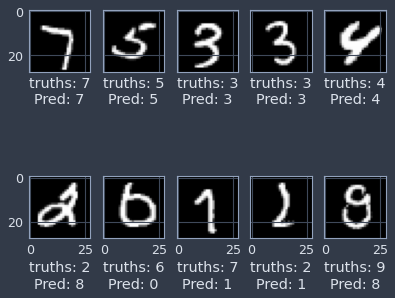

With sigma = 0.0, the number of images going to wrong is: 14 / 2000 (images)


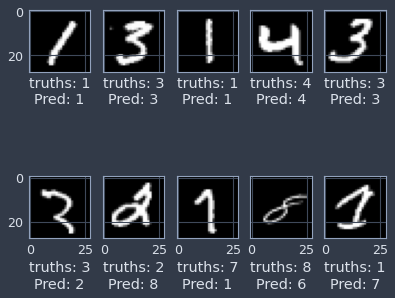

With sigma = 50.0, the number of images going to wrong is: 218 / 2000 (images)


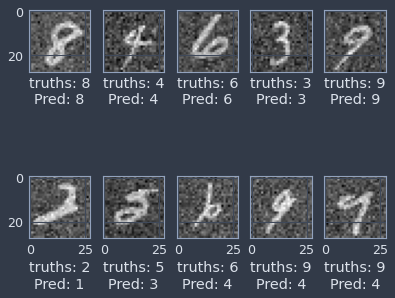

With sigma = 50.0, the number of images going to wrong is: 520 / 2000 (images)


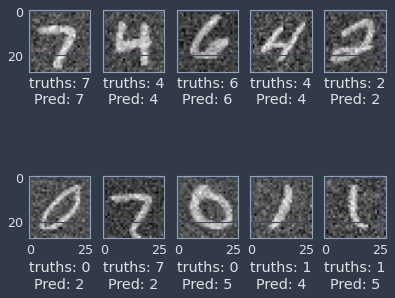

With sigma = 75.0, the number of images going to wrong is: 497 / 2000 (images)


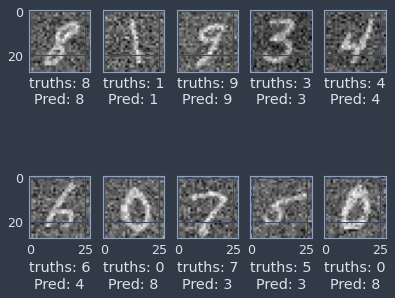

With sigma = 75.0, the number of images going to wrong is: 671 / 2000 (images)


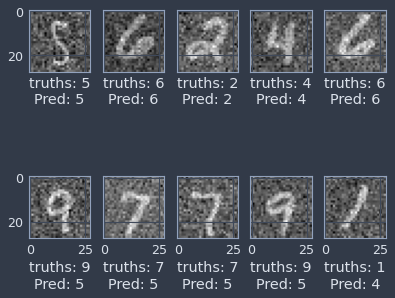

With sigma = 100.0, the number of images going to wrong is: 691 / 2000 (images)


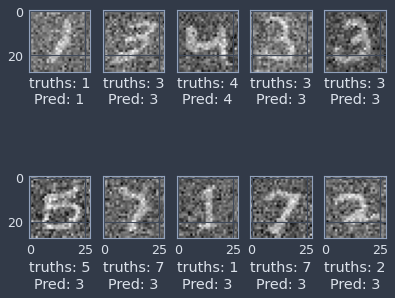

With sigma = 100.0, the number of images going to wrong is: 754 / 2000 (images)


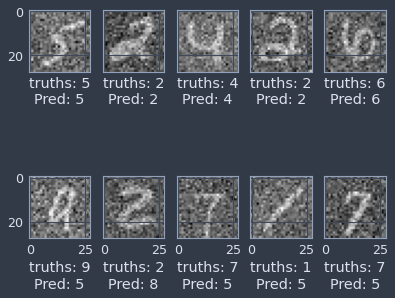

In [20]:
def visualize_model(model,data, typ="ode", sigma = 50.0):
    import random
    cnt = 0
    tr = []; fal = []
    for _, dp in list(enumerate(data)):
        np_dp = torch.tensor(np.array(dp[0]).reshape((1,1,28,28))).float()
        np_dp = np_dp + torch.normal(torch.zeros(np_dp.shape),torch.ones(np_dp.shape) * sigma).float()
        np_dp = np_dp.to(device)
        preds = model(np_dp)
        preds = torch.argmax(preds,dim=1).item()
        if preds == dp[1]:  tr.append((np_dp,dp[1],preds))
        else: fal.append((np_dp,dp[1],preds))
        cnt+=1
        if cnt == 1001: break
    print(f"With sigma = {sigma}, the number of images going to wrong is: {len(fal)} / 2000 (images)")
    random.shuffle(tr)
    random.shuffle(fal)
    fig, ax = plt.subplots(2,5,sharex=True,sharey=True)
    for i in range(5):
        ax[0][i].imshow(tr[i][0].cpu().detach().numpy().reshape((28,28)),cmap="gray")
        ax[0][i].set_xlabel(f"truths: {tr[i][1]}\nPred: {tr[i][2]}")
        ax[1][i].imshow(fal[i][0].cpu().detach().numpy().reshape((28,28)),cmap="gray")
        ax[1][i].set_xlabel(f"truths: {fal[i][1]}\nPred: {fal[i][2]}")
    #plt.xlabel(f"{typ} model with sigma {sigma}")
    plt.show()
    
sigma_l = [0.0, 50.0, 75.0, 100.0]
for sig in sigma_l:
    visualize_model(ode_model, MNIST, typ="odenet", sigma=sig)
    visualize_model(cnn_model, MNIST, typ="cnnnet", sigma=sig)

In [10]:
_ds_len, _ds = preprocess_data(MNIST)

print(_ds)

Generating None-pertubed-dataset
